# Technical assesment - Juan David García Castro 

# 1) Data loading a processing.

In [1]:
import os
import numpy as np
import pandas as pd, datetime
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import itertools
import xgboost as xgb
import warnings
from time import time
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.arima_model import  ARIMA
from sklearn import model_selection
from sklearn.metrics import mean_squared_error, r2_score
from pandas import DataFrame
from fbprophet import Prophet

warnings.filterwarnings('ignore')
get_ipython().run_line_magic('matplotlib', 'inline')



In [2]:
df = pd.read_csv('./input (1).csv')

In [3]:
df.head()

,dt,grp_A_1,grp_B_1,grp_A_2,grp_B_2,grp_A_3,grp_B_3,grp_A_4,grp_B_4,grp_A_5,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,units_sold
0,11/7/2017,389.5,56.63,8392.0,52.125,8462.0,33.875,1177.0,15.375,170428.0,...,11.0,1.0,192.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0
1,12/7/2017,389.5,56.63,8392.0,52.125,8462.0,33.875,1177.0,15.375,170428.0,...,12.0,2.0,193.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0
2,13/07/2017,389.5,56.63,8392.0,52.125,8462.0,33.875,1177.0,15.375,170428.0,...,13.0,3.0,194.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0
3,14/07/2017,389.5,56.63,8392.0,52.125,8462.0,33.875,1177.0,15.375,170428.0,...,14.0,4.0,195.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0
4,15/07/2017,389.5,56.63,8392.0,52.125,8462.0,33.875,1177.0,15.375,170428.0,...,15.0,5.0,196.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0


In [4]:
df.tail()

,dt,grp_A_1,grp_B_1,grp_A_2,grp_B_2,grp_A_3,grp_B_3,grp_A_4,grp_B_4,grp_A_5,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,units_sold
748,29/07/2019,260.50,70.91,13397.0,66.867857,6058.428571,41.346429,2484.0,28.017857,228112.4286,...,29.0,0.0,210.0,0.0,0.0,0.0,0.0,0.0,0.0,182.0
749,30/07/2019,249.50,70.70,13008.0,66.110714,5902.857143,38.817857,2468.0,28.660714,221786.8571,...,30.0,1.0,211.0,0.0,0.0,0.0,0.0,0.0,0.0,146.0
750,31/07/2019,238.50,70.48,12619.0,65.353571,5747.285714,36.289286,2452.0,29.303571,215461.2857,...,31.0,2.0,212.0,1.0,0.0,0.0,0.0,0.0,0.0,133.0
751,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
752,NaN,-0.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.shape

(753, 129)

## Data information.

* Daily sales data from an online store of one product. 

* The dependent variable is units_sold 

* We have data until July 31 of the year 2019


### Converting **dt** column to date_time format. This works better for _ARIMA_ and _SARIMAX_ algorithms.

In [6]:
df.rename(columns={'dt': 'date','units_sold':'sales'},inplace=True)


In [7]:
df['date'] = pd.to_datetime(df['date'])

In [8]:
df.head()

,date,grp_A_1,grp_B_1,grp_A_2,grp_B_2,grp_A_3,grp_B_3,grp_A_4,grp_B_4,grp_A_5,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,sales
0,2017-11-07,389.5,56.63,8392.0,52.125,8462.0,33.875,1177.0,15.375,170428.0,...,11.0,1.0,192.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0
1,2017-12-07,389.5,56.63,8392.0,52.125,8462.0,33.875,1177.0,15.375,170428.0,...,12.0,2.0,193.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0
2,2017-07-13,389.5,56.63,8392.0,52.125,8462.0,33.875,1177.0,15.375,170428.0,...,13.0,3.0,194.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0
3,2017-07-14,389.5,56.63,8392.0,52.125,8462.0,33.875,1177.0,15.375,170428.0,...,14.0,4.0,195.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0
4,2017-07-15,389.5,56.63,8392.0,52.125,8462.0,33.875,1177.0,15.375,170428.0,...,15.0,5.0,196.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0


In [9]:
df['date'].head()

0   2017-11-07
1   2017-12-07
2   2017-07-13
3   2017-07-14
4   2017-07-15
Name: date, dtype: datetime64[ns]

In [10]:
df.set_index('date',inplace=True)

In [11]:
df.head()

,grp_A_1,grp_B_1,grp_A_2,grp_B_2,grp_A_3,grp_B_3,grp_A_4,grp_B_4,grp_A_5,grp_B_5,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,sales
date,,,,,,,,,,,,,,,,,,,,,
2017-11-07,389.5,56.63,8392.0,52.125,8462.0,33.875,1177.0,15.375,170428.0,81.25,...,11.0,1.0,192.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0
2017-12-07,389.5,56.63,8392.0,52.125,8462.0,33.875,1177.0,15.375,170428.0,81.25,...,12.0,2.0,193.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0
2017-07-13,389.5,56.63,8392.0,52.125,8462.0,33.875,1177.0,15.375,170428.0,81.25,...,13.0,3.0,194.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0
2017-07-14,389.5,56.63,8392.0,52.125,8462.0,33.875,1177.0,15.375,170428.0,81.25,...,14.0,4.0,195.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0
2017-07-15,389.5,56.63,8392.0,52.125,8462.0,33.875,1177.0,15.375,170428.0,81.25,...,15.0,5.0,196.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0


In [12]:
df.dropna(axis=0,inplace=True)

In [13]:
df.isnull().sum()

grp_A_1             0
grp_B_1             0
grp_A_2             0
grp_B_2             0
grp_A_3             0
                   ..
Is_quarter_end      0
Is_quarter_start    0
Is_year_end         0
Is_year_start       0
sales               0
Length: 128, dtype: int64

### In the dataset we have daily sales but the customer is interested in monthly sales so we are going to change that. 

In [14]:
df = df.resample('M').sum()

In [15]:
df.head()

,grp_A_1,grp_B_1,grp_A_2,grp_B_2,grp_A_3,grp_B_3,grp_A_4,grp_B_4,grp_A_5,grp_B_5,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,sales
date,,,,,,,,,,,,,,,,,,,,,
2017-01-31,3787.07,245.03,92317.71428,219.375000,57287.428570,137.553571,26347.571430,77.553571,1.368979e+06,359.500000,...,5.0,17.0,1371.0,0.0,5.0,0.0,1.0,0.0,0.0,173.0
2017-02-28,3874.51,241.96,95448.28572,216.160714,57956.714286,135.482143,27707.571424,77.696429,1.399663e+06,354.678571,...,10.0,15.0,1376.0,0.0,0.0,0.0,0.0,0.0,0.0,172.0
2017-03-31,3961.93,238.89,98578.85714,212.946429,58626.000000,133.410714,29067.571429,77.839286,1.430348e+06,349.857143,...,15.0,20.0,1381.0,0.0,0.0,0.0,0.0,0.0,0.0,166.0
2017-04-30,4167.79,236.02,103396.85715,209.596429,60308.428570,130.175000,30959.857143,77.689286,1.482163e+06,345.357143,...,20.0,11.0,1386.0,0.0,0.0,0.0,0.0,0.0,0.0,148.0
2017-05-31,4373.64,233.17,108214.85714,206.246429,61990.857140,126.939286,32852.142857,77.539286,1.533978e+06,340.857143,...,25.0,16.0,1391.0,0.0,0.0,0.0,0.0,0.0,0.0,150.0


In [16]:
df.tail(6)

,grp_A_1,grp_B_1,grp_A_2,grp_B_2,grp_A_3,grp_B_3,grp_A_4,grp_B_4,grp_A_5,grp_B_5,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,sales
date,,,,,,,,,,,,,,,,,,,,,
2019-07-31,11059.0,1712.73,474305.0,1582.257143,186941.571428,993.878571,101660.0,674.457143,6.316187e+06,1089.15,...,467.0,79.0,4538.0,1.0,0.0,0.0,0.0,0.0,0.0,4012.0
2019-08-31,5966.5,362.56,214705.0,301.925000,69809.000000,175.425000,54256.0,150.475000,1.899818e+06,224.85,...,56.0,16.0,688.0,0.0,0.0,0.0,0.0,0.0,0.0,700.0
2019-09-30,5966.5,362.56,214705.0,301.925000,69809.000000,175.425000,54256.0,150.475000,1.899818e+06,224.85,...,63.0,23.0,695.0,0.0,0.0,0.0,0.0,0.0,0.0,688.0
2019-10-31,5966.5,362.56,214705.0,301.925000,69809.000000,175.425000,54256.0,150.475000,1.899818e+06,224.85,...,70.0,23.0,702.0,0.0,0.0,0.0,0.0,0.0,0.0,642.0
2019-11-30,5966.5,362.56,214705.0,301.925000,69809.000000,175.425000,54256.0,150.475000,1.899818e+06,224.85,...,77.0,16.0,709.0,0.0,0.0,0.0,0.0,0.0,0.0,614.0
2019-12-31,5966.5,362.56,214705.0,301.925000,69809.000000,175.425000,54256.0,150.475000,1.899818e+06,224.85,...,84.0,23.0,716.0,0.0,0.0,0.0,0.0,0.0,0.0,587.0


In [17]:
df.drop(df.tail(5).index,inplace=True) # drop last n rows

In [18]:
df.tail()

,grp_A_1,grp_B_1,grp_A_2,grp_B_2,grp_A_3,grp_B_3,grp_A_4,grp_B_4,grp_A_5,grp_B_5,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,sales
date,,,,,,,,,,,,,,,,,,,,,
2019-03-31,33664.49,840.49,1.229891e+06,652.603571,337402.857146,448.403571,287696.428576,339.989286,9.053643e+06,589.450000,...,439.0,85.0,2192.0,1.0,0.0,1.0,0.0,0.0,0.0,1725.0
2019-04-30,13417.79,1541.74,6.232423e+05,1314.839286,244780.857134,689.803571,128198.428574,694.589286,6.346386e+06,1196.071429,...,415.0,70.0,2667.0,1.0,0.0,0.0,0.0,0.0,0.0,2133.0
2019-05-31,10998.22,1777.05,4.404066e+05,1483.582143,230568.142857,783.082143,127699.142858,795.682143,6.216899e+06,1081.735714,...,453.0,75.0,3365.0,1.0,0.0,0.0,0.0,0.0,0.0,3350.0
2019-06-30,11563.93,1715.21,4.205946e+05,1381.389286,208053.428570,718.253571,118468.714286,725.625000,6.315195e+06,907.400000,...,429.0,83.0,3779.0,1.0,0.0,1.0,0.0,0.0,0.0,3877.0
2019-07-31,11059.00,1712.73,4.743050e+05,1582.257143,186941.571428,993.878571,101660.000000,674.457143,6.316187e+06,1089.150000,...,467.0,79.0,4538.0,1.0,0.0,0.0,0.0,0.0,0.0,4012.0


In [19]:
fig = px.line(df,x = df.index ,y='sales')
fig.update_layout(title='Units sold by month',  
                  xaxis_title="Months",
                  yaxis_title=" Units sold"
                  )
fig.show()

In [20]:
fig = px.bar(df, x=df.index, y="sales")
fig.update_layout(title='Units sold by month',  
                  xaxis_title="Months",
                  yaxis_title=" Units sold"
                  )
fig.show()

# Testing for stationarity 

In [25]:
# HO : The data is not stationary.  
# H1 : The data is stationary. 
def adfuller_test(sales):
    result = adfuller(sales)
    labels = ['ADF test Statistic','p-value','#Lags Used','Number of observations used']
    for value,label in zip(result,labels):
        print(label + ':' + str(value))
    if  result[1] <= 0.05:
        print('Strong evidence against the null hypothesis')
    else:
        print('Weak evidence against null hypothesis, time series has a unit root, indicating it is not stationary')        

In [22]:
adfuller_test(df['sales'])

ADF test Statistic:-1.1096440413706872
p-value:0.7112106891948348
#Lags Used:7
Number of observations used:23
Weak evidence against null hypothesis, time series has a unit root, indicating it is not stationary


## Based on the plots and the previous hypotesis testing, the  data is not stationary it can be seen that from May to August there are some peaks in the sales. 

## So, in order to apply  a forecasting method we need  _**stationary data**_. This means that the data needs to have constant _mean_, constant _variance_ and constant _covariance_ with time. 

In [33]:
df['Sales first difference'] = (df['sales'] - df['sales'].shift(1))

<AxesSubplot:xlabel='date'>

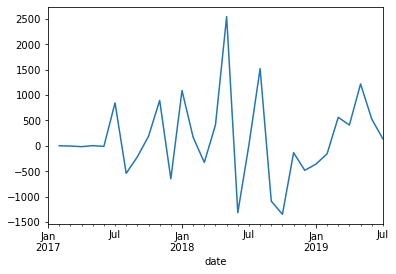

In [36]:
df['Sales first difference'].plot()

In [35]:
adfuller_test(df['Sales first difference'].dropna())

ADF test Statistic:-2.9499658544804364
p-value:0.03983856417029879
#Lags Used:6
Number of observations used:23
Strong evidence against the null hypothesis


## The p-value is less than 0.05 which lead us to reject the null hypotesis so now that the data is stationary and we can apply the forecasting methods. 

# Autoregresive model. 

## How many previous days we have to take in count for making the prediction. 

In [41]:
# Autocorrelation function to make ACF and PACF graphs
def auto_corr(sales):
    lag_acf = acf(sales,nlags=30)
    lag_pacf = pacf(sales,nlags=10,method='ols')
  
    plt.subplot(121)
    plt.plot(lag_acf)
    plt.axhline(y=0,linestyle='--',color ='red')
    plt.axhline(y=1.96/np.sqrt(len(df['sales'])),linestyle='--',color ='red')
    plt.axhline(y=-1.96/np.sqrt(len(df['sales'])),linestyle='--',color ='red')
    plt.title('ACF')
    
    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0,linestyle='--',color ='red')
    plt.axhline(y=1.96/np.sqrt(len(df['sales'])),linestyle='--',color ='red')
    plt.axhline(y=-1.96/np.sqrt(len(df['sales'])),linestyle='--',color ='red')
    plt.title('PACF')

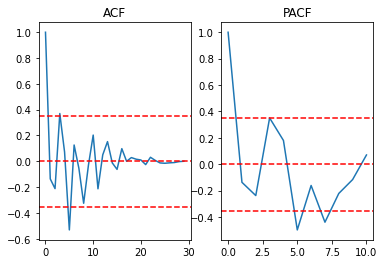

In [52]:

# ACF and PACF for store type a
auto_corr(df['Sales first difference'].dropna())

In [43]:
# Define the p, d and q parameters to take any value between 0 and 3
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA: ')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA: 
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [47]:
df

,grp_A_1,grp_B_1,grp_A_2,grp_B_2,grp_A_3,grp_B_3,grp_A_4,grp_B_4,grp_A_5,grp_B_5,...,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,sales,Sales first difference
date,,,,,,,,,,,,,,,,,,,,,
2017-01-31,3787.07,245.03,9.231771e+04,219.375000,57287.428570,137.553571,26347.571430,77.553571,1.368979e+06,359.500000,...,17.0,1371.0,0.0,5.0,0.0,1.0,0.0,0.0,173.0,NaN
2017-02-28,3874.51,241.96,9.544829e+04,216.160714,57956.714286,135.482143,27707.571424,77.696429,1.399663e+06,354.678571,...,15.0,1376.0,0.0,0.0,0.0,0.0,0.0,0.0,172.0,-1.0
2017-03-31,3961.93,238.89,9.857886e+04,212.946429,58626.000000,133.410714,29067.571429,77.839286,1.430348e+06,349.857143,...,20.0,1381.0,0.0,0.0,0.0,0.0,0.0,0.0,166.0,-6.0
2017-04-30,4167.79,236.02,1.033969e+05,209.596429,60308.428570,130.175000,30959.857143,77.689286,1.482163e+06,345.357143,...,11.0,1386.0,0.0,0.0,0.0,0.0,0.0,0.0,148.0,-18.0
2017-05-31,4373.64,233.17,1.082149e+05,206.246429,61990.857140,126.939286,32852.142857,77.539286,1.533978e+06,340.857143,...,16.0,1391.0,0.0,0.0,0.0,0.0,0.0,0.0,150.0,2.0
2017-06-30,4466.93,231.06,1.108686e+05,204.139286,62795.571430,125.617857,33902.428571,77.717857,1.560063e+06,340.821429,...,14.0,1396.0,0.0,0.0,0.0,0.0,0.0,0.0,137.0,-13.0
2017-07-31,11960.71,1304.92,2.729703e+05,1192.407143,224378.285710,767.921429,57315.714286,370.021429,4.824280e+06,1884.535714,...,72.0,5258.0,1.0,0.0,0.0,0.0,0.0,0.0,981.0,844.0
2017-08-31,12054.00,1302.82,2.756240e+05,1190.300000,225183.000000,766.600000,58366.000000,370.200000,4.850365e+06,1884.500000,...,71.0,5852.0,1.0,0.0,0.0,0.0,0.0,0.0,437.0,-544.0
2017-09-30,11664.50,1246.19,2.672320e+05,1138.175000,216721.000000,732.725000,57189.000000,354.825000,4.679937e+06,1803.250000,...,71.0,6172.0,1.0,0.0,1.0,0.0,0.0,0.0,219.0,-218.0


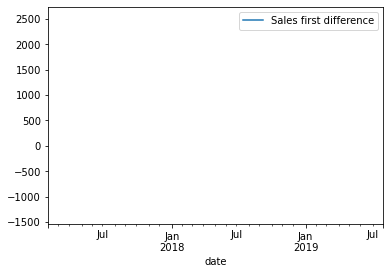

In [57]:
train_arima = df.resample("W").mean() 
train_arima = train_arima[["Sales first difference"]]
train_arima.plot();

In [55]:
# Determing p,d,q combinations with AIC scores.
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_arima,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:489.41702323359743
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:445.17719450841105
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:466.0053813703728
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:436.7617665873525
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:460.8020311131493
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:447.1726289543283
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:699431251844.9552
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:687.099424319862
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:491.4133761613367
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:443.6664681702317
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:467.86573263432376
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:438.64944070404056
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:460.094328001757
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:445.40413524570664
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:753.9514104653434
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:471.42837817394076
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:691.295370019003
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:464.3730560453093
ARIMA(0

#### The best combination was ARIMA(0, 1, 1) x (0, 1, 1, 12)12 - AIC:431.7667631453826

In [56]:

# Fitting the data to SARIMA model 
model_sarima = sm.tsa.statespace.SARIMAX(train_arima,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results_sarima = model_sarima.fit()

print(results_sarima.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         33.2638    646.141      0.051      0.959   -1233.149    1299.677
ma.S.L12       8.7991     37.519      0.235      0.815     -64.737      82.335
sigma2         3.1026    127.396      0.024      0.981    -246.588     252.793


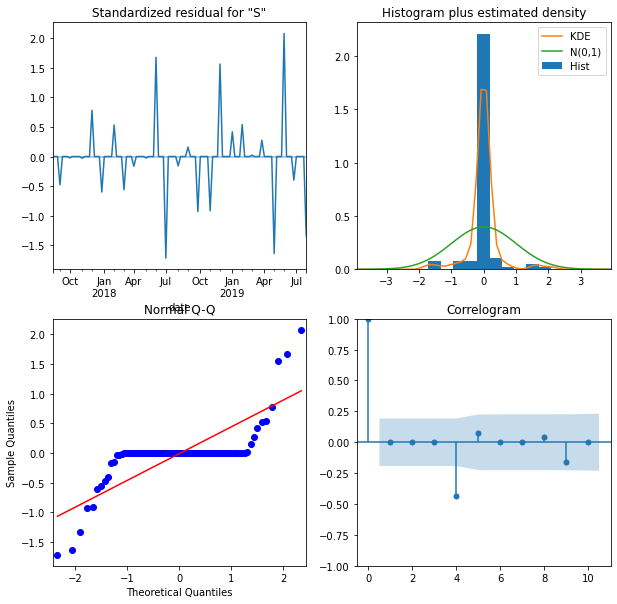

In [58]:
# Checking diagnostic plots
results_sarima.plot_diagnostics(figsize=(10, 10))
plt.show()